## Preparing the target distribution of the MCMC Algorithms

Preparing the dataset of Gaussian Mixture Model with 4 components.  

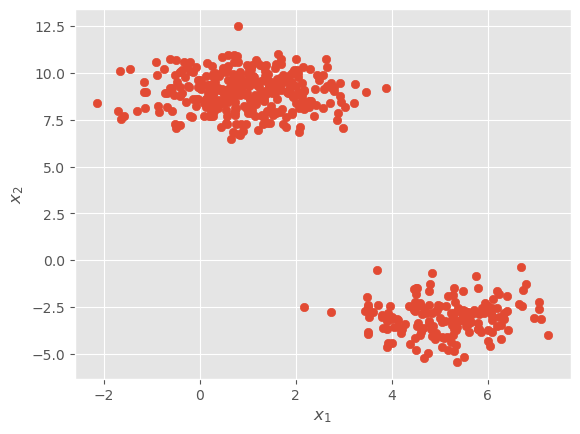

In [30]:
from MCMC_DianZhang.Dian_BayesianInference.Dian_BayesianInference.GMM_datagen import Data_params_gen_GMM
import matplotlib.pyplot as plt

GMM_data_2D_4com = Data_params_gen_GMM(n_components=2, n_dimensions=2)
_,_ = GMM_data_2D_4com.generate(datasize=500)

with plt.style.context("ggplot"):
    plt.scatter(GMM_data_2D_4com.noisy_Dataset[:, 0], GMM_data_2D_4com.noisy_Dataset[:, 1])
    plt.xlabel("$x_1$")

    plt.ylabel("$x_2$")
    plt.show()

Defining the Likelihood function with the dataset generated above.  

In [31]:
from MCMC_DianZhang.Dian_BayesianInference.Dian_BayesianInference.log_Likeli_GMM import Likeli_GMM_mus

GMM_Likeli_2D_4com = Likeli_GMM_mus(Dataset=GMM_data_2D_4com.noisy_Dataset, Sigmas=GMM_data_2D_4com.Sigmas, weights=GMM_data_2D_4com.weights, n_components=GMM_data_2D_4com.n_components)

In [34]:
from MCMC_DianZhang.Dian_MCMC.MetropolisHastingMCMC.MHMC import MHMC
from MCMC_DianZhang.Dian_MCMC.MetropolisHastingMCMC.ProposalDistributions import  GaussianProposalDistribution
steps = 10000
Prop = GaussianProposalDistribution(sd=0.15, Dim=GMM_Likeli_2D_4com.n_dimensions*GMM_Likeli_2D_4com.n_components)
MHMC_GMM_2D_4com = MHMC(rho=GMM_Likeli_2D_4com.calculate_log_likelihoods, log_likelihood=True)
MCMC_outputs, acc = MHMC_GMM_2D_4com.generate(
    theta0=[0 for _ in range(GMM_Likeli_2D_4com.n_dimensions*GMM_Likeli_2D_4com.n_components)], 
    qProb=Prop.qProb, 
    qSamp=Prop.qSample, 
    steps=steps
    )

/Users/zhangdian/Documents/GitHub/MResMCMC2023/MCMC_DianZhang/Dian_MCMC/MetropolisHastingMCMC/MHMC.py:74: RuntimeWarning: overflow encountered in exp
  self.alpha = min(1, np.exp(self.rho(self.theta_nPlus1) + np.log(qProb(self.theta_nPlus1,self.theta_n)) - (self.rho(self.theta_n) + np.log(qProb(self.theta_n,self.theta_nPlus1)))))


The acceptance rate of the MCMC algorithm = 0.091


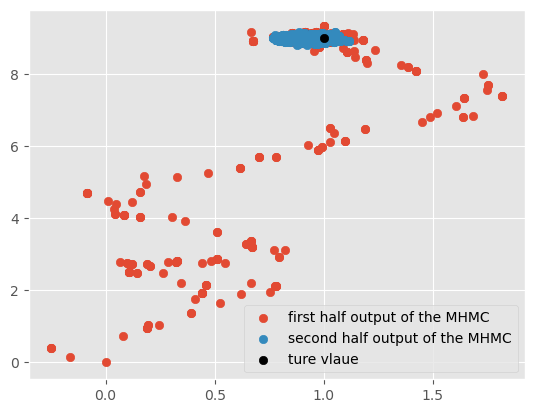

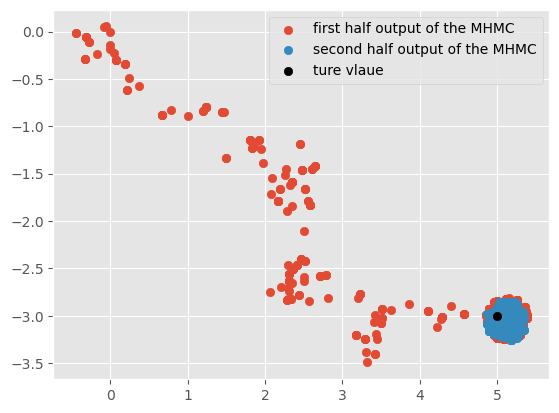

In [36]:
import numpy as np

MCMC_outputs = np.asarray(MCMC_outputs)
print(f"The acceptance rate of the MCMC algorithm = {acc:.3f}")
with plt.style.context("ggplot"):
    for i in range(GMM_Likeli_2D_4com.n_components):
        plt.scatter(MCMC_outputs[:steps//2, i*2], MCMC_outputs[:steps//2, i*2+1], label="first half output of the MHMC")
        plt.scatter(MCMC_outputs[steps//2:, i*2], MCMC_outputs[steps//2:, i*2+1], label="second half output of the MHMC")
        plt.scatter(GMM_data_2D_4com.mus[i][0], GMM_data_2D_4com.mus[i][1], label="ture vlaue", color="black")
        plt.legend()
        plt.show()